Before we get started, a couple of reminders to keep in mind when using iPython notebooks:

- Remember that you can see from the left side of a code cell when it was last run if there is a number within the brackets.
- When you start a new notebook session, make sure you run all of the cells up to the point where you last left off. Even if the output is still visible from when you ran the cells in your previous session, the kernel starts in a fresh state so you'll need to reload the data, etc. on a new session.
- The previous point is useful to keep in mind if your answers do not match what is expected in the lesson's quizzes. Try reloading the data and run all of the processing steps one by one in order to make sure that you are working with the same variables and data that are at each quiz stage.


## Load Data from CSVs

In [84]:
import unicodecsv


def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

In [85]:
enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')

## Fixing Data Types

In [86]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [87]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [88]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

### Questions on Data:

    1. What is most critical lesson for students not finishing the course?
    2. Which lesson takes the most effort?
    3. Average number of efforts for project submission
    4. What percentage of students succeeds with the course
    5. How much time do students spend per day on the course on average?
    
    

Note when running the above cells that we are actively changing the contents of our data variables. If you try to run these cells multiple times in the same session, an error will occur.

## Investigating the Data

In [89]:
enrollment_num_rows = len(enrollments)
enrollment_num_unique_students = len(set(enrollment['account_key'] for enrollment in enrollments))
engagement_num_rows = len(daily_engagement)
engagement_num_unique_students = len(set(eng['acct'] for eng in daily_engagement))
submission_num_rows = len(project_submissions)
submission_num_unique_students =  len(set(submission['account_key'] for submission in project_submissions))

## Problems in the Data

## Rename the "acct" column in the daily_engagement table to "account_key".

In [90]:
for engagement_record in daily_engagement:
    engagement_record['account_key'] = engagement_record['acct']
    del engagement_record['acct'] 
    

## Missing Engagement Records

In [91]:
unique_enrolled_students = set(enrollment['account_key'] for enrollment in enrollments)
unique_engagement_students = set(eng['account_key'] for eng in daily_engagement)

for enrollment in enrollments:
    account_key = enrollment['account_key']
    if account_key not in unique_engagement_students:
        print enrollment
        break


{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}


## Checking for More Problem Records

In [92]:
for enrollment in enrollments:
    account_key = enrollment['account_key']
    days_to_cancel = enrollment['days_to_cancel']
    if account_key not in unique_engagement_students and days_to_cancel != 0:
        print enrollment

{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 1, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 3, 10, 0, 0), u'days_to_cancel': 59}
{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 3, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 6, 17, 0, 0), u'days_to_cancel': 99}
{u'status': u'current', u'is_udacity': True, u'is_canceled': False, u'join_date': datetime.datetime(2015, 2, 25, 0, 0), u'account_key': u'1101', u'cancel_date': None, u'days_to_cancel': None}


## Tracking Down the Remaining Problems

In [93]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [94]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [95]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


## Refining the Question

In [96]:
paid_students = {}
for enrollment in non_udacity_enrollments:
    if (not enrollment['is_canceled'] or
            enrollment['days_to_cancel'] > 7):
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        if (account_key not in paid_students or
                enrollment_date > paid_students[account_key]):
            paid_students[account_key] = enrollment_date
len(paid_students)

995

## Getting Data from First Week

In [97]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data

In [98]:
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

print len(paid_enrollments)
print len(paid_engagement)
print len(paid_submissions)

paid_engagement_in_first_week = []
for engagement_record in paid_engagement:
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']

    if within_one_week(join_date, engagement_record_date):
         paid_engagement_in_first_week.append(engagement_record)

len(paid_engagement_in_first_week)  

1293
134549
3618


6919

## Exploring Student Engagement

In [99]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [100]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [101]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = total_minutes_by_account.values()
print 'Mean:', np.mean(total_minutes)
print 'Standard deviation:', np.std(total_minutes)
print 'Minimum:', np.min(total_minutes)
print 'Maximum:', np.max(total_minutes)

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


## Debugging Data Analysis Code

In [102]:
student_with_max_minutes = None
max_minutes = 0

for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > max_minutes:
        max_minutes = total_minutes
        student_with_max_minutes = student

max_minutes

for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] == student_with_max_minutes:
        print engagement_record

{u'lessons_completed': 4, u'num_courses_visited': 4, u'total_minutes_visited': 850.519339666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 9, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 6, u'total_minutes_visited': 872.633923334, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 10, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 2, u'total_minutes_visited': 777.018903666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 11, 0, 0)}
{u'lessons_completed': 2, u'num_courses_visited': 1, u'total_minutes_visited': 294.568774, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 12, 0, 0)}
{u'lessons_completed': 1, u'num_courses_visited': 3, u'total_minutes_visited': 471.2139785, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 13, 0, 0)}
{u'lessons_completed': 1, u'num_cour

## Lessons Completed in First Week

In [103]:
from collections import defaultdict

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week,
                                   'account_key')

def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data

total_minutes_by_account = sum_grouped_items(engagement_by_account,
                                             'total_minutes_visited')

import numpy as np

def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maximum:', np.max(data)

describe_data(total_minutes_by_account.values())

lessons_completed_by_account = sum_grouped_items(engagement_by_account,
                                                 'lessons_completed')
describe_data(lessons_completed_by_account.values())

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645
Mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maximum: 36


## Number of Visits in First Week

In [104]:
for engagement_record in paid_engagement:
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0

days_visited_by_account = sum_grouped_items(engagement_by_account,
                                            'has_visited')
describe_data(days_visited_by_account.values())

Mean: 2.86733668342
Standard deviation: 2.25519800292
Minimum: 0
Maximum: 7


## Splitting out Passing Students

In [105]:
subway_project_lesson_keys = ['746169184', '3176718735']

pass_subway_project = set()

for submission in paid_submissions:
    project = submission['lesson_key']
    rating = submission['assigned_rating']    

    if ((project in subway_project_lesson_keys) and
            (rating == 'PASSED' or rating == 'DISTINCTION')):
        pass_subway_project.add(submission['account_key'])

len(pass_subway_project)

passing_engagement = []
non_passing_engagement = []

for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] in pass_subway_project:
        passing_engagement.append(engagement_record)
    else:
        non_passing_engagement.append(engagement_record)

print len(passing_engagement)
print len(non_passing_engagement)

4527
2392


## Comparing the Two Student Groups

non-passing students (minutes):
Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933
passing students (minutes):
Mean: 394.586046484
Standard deviation: 448.499519327
Minimum: 0.0
Maximum: 3564.7332645
non-passing students (lessons):
Mean: 0.862068965517
Standard deviation: 2.54915994183
Minimum: 0
Maximum: 27
passing students (lessons):
Mean: 2.05255023184
Standard deviation: 3.14222705558
Minimum: 0
Maximum: 36
non-passing students (days visited):
Mean: 1.90517241379
Standard deviation: 1.90573144136
Minimum: 0
Maximum: 7
passing students (days vistied):
Mean: 3.38485316847
Standard deviation: 2.25882147092
Minimum: 0
Maximum: 7


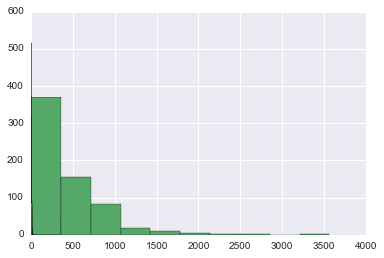

In [112]:
passing_engagement_by_account = group_data(passing_engagement,
                                           'account_key')
non_passing_engagement_by_account = group_data(non_passing_engagement,
                                               'account_key')

print 'non-passing students (minutes):'
non_passing_minutes = sum_grouped_items(
    non_passing_engagement_by_account,
    'total_minutes_visited'
)
describe_data(non_passing_minutes.values())

print 'passing students (minutes):'
passing_minutes = sum_grouped_items(
    passing_engagement_by_account,
    'total_minutes_visited'
)
describe_data(passing_minutes.values())

print 'non-passing students (lessons):'
non_passing_lessons = sum_grouped_items(
    non_passing_engagement_by_account,
    'lessons_completed'
)
describe_data(non_passing_lessons.values())

print 'passing students (lessons):'
passing_lessons = sum_grouped_items(
    passing_engagement_by_account,
    'lessons_completed'
)
describe_data(passing_lessons.values())

print 'non-passing students (days visited):'
non_passing_visits = sum_grouped_items(
    non_passing_engagement_by_account, 
    'has_visited'
)
describe_data(non_passing_visits.values())

print 'passing students (days vistied):'
passing_visits = sum_grouped_items(
    passing_engagement_by_account,
    'has_visited'
)
describe_data(passing_visits.values())

## Making Histograms

In [107]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np

# Summarize the given data
def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maximum:', np.max(data)
    plt.hist(data)

Populating the interactive namespace from numpy and matplotlib


## Improving Plots and Sharing Findings

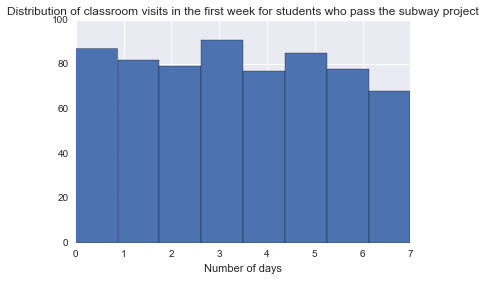

In [108]:
import seaborn as sns


plt.hist(passing_visits.values(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who pass the subway project')


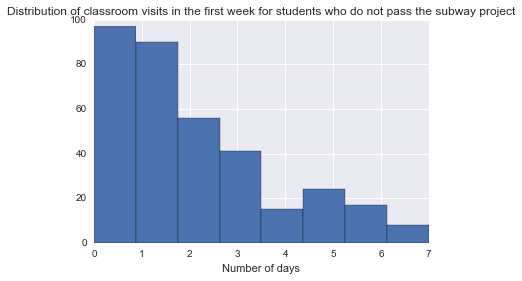

In [109]:

plt.hist(non_passing_visits.values(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' + 
          'for students who do not pass the subway project')


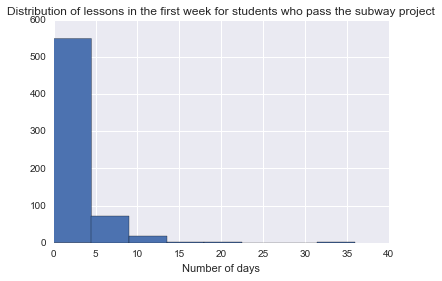

In [110]:
plt.hist(passing_lessons.values(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of lessons in the first week ' + 
          'for students who pass the subway project')


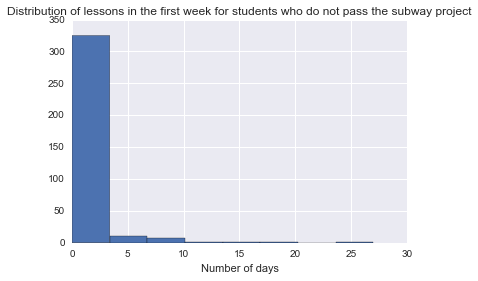

In [111]:
plt.hist(non_passing_lessons.values(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of lessons in the first week ' + 
          'for students who do not pass the subway project')